### The dprime calculator liberary 

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

#   Copyright (C) 2012-2017 Samuele Carcagno <sam.carcagno@gmail.com>
#   This file is part of pysdt

#    pysdt is free software: you can redistribute it and/or modify
#    it under the terms of the GNU General Public License as published by
#    the Free Software Foundation, either version 3 of the License, or
#    (at your option) any later version.

#    pysdt is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#    GNU General Public License for more details.

#    You should have received a copy of the GNU General Public License
#    along with pysdt.  If not, see <http://www.gnu.org/licenses/>.

"""
A module for computing signal detection theory measures.
Some of the functions in this module have been ported to
python from the 'psyphy' R package of Kenneth Knoblauch
http://cran.r-project.org/web/packages/psyphy/index.html
"""
from __future__ import nested_scopes, generators, division, absolute_import, with_statement, print_function, unicode_literals
from scipy.stats import norm
from scipy.integrate import quad
from scipy.special import erf, erfinv
from scipy import Inf
import numpy, scipy
from numpy import exp, log, log10, sign, sqrt
import numpy as np
#from numpy.lib.scimath import logn #log with arbitrary base


def compute_proportions(nCA, nTA, nIB, nTB, corr):
    """
    Compute proportions with optional corrections for extreme proportions.

    Parameters
    ----------
    nCA : float
        Number of correct 'A' trials
    nTA : int
        Number of total 'A' trials
    nIB : float
        Number of incorrect 'B' trials
    nTB : int
        Number of total 'B' trials
    corr : string
        The correction to apply, `none` for no correction, 'loglinear` for the
        log-linear correction, and `2N` for the '2N' correction.

    Returns
    -------
    HR : float
        Hit rate
    FA : float
        False alarm rate

    Examples
    --------
    >>> H,F = compute_proportions(8, 10, 2, 10, "loglinear")
    >>> H,F = compute_proportions(10, 10, 2, 10, "loglinear")
    >>> H,F = compute_proportions(10, 10, 2, 10, "2N")

    References
    ----------
   .. [1] Hautus, M. J. (1995). Corrections for extreme proportions and their biasing effects on estimated values of *d'*. *Behavior Research Methods, Instruments, & Computers, 27(I)*, 46–51. http://doi.org/10.3758/BF03203619
   .. [2] Macmillan, N. A., & Creelman, C. D. (2004). *Detection Theory: A User’s Guide (2nd ed.)*. London: Lawrence Erlbraum Associates.

    
    """
    if corr == "loglinear":
        HR = (nCA+0.5)/(nTA+1)
        FR = (nIB+0.5)/(nTB+1)
    elif corr == "2N":
        if nCA == nTA:
            HR = 1 - 1/(2*nTA)
        elif nCA == 0:
            HR = 1 / (2*nTA)
        else:
            HR = nCA/(nTA)

        if nIB == nTB:
            FR = 1 - 1/(2*nTB)
        elif nIB == 0:
            FR = 1 / (2*nTB)
        else:
            FR = nIB/(nTB)
    else:
        HR = nCA/nTA
        FR = nIB/nTB

    return HR, FR



def dprime_mAFC(Pc, m):
    """
    Compute *d'* corresponding to a certain proportion of correct
    responses in m-AFC tasks.

    Parameters
    ----------
    Pc : float
        Proportion of correct responses.
    m : int
        Number of alternatives.

    Returns
    -------
    dprime : float
        *d'* value

    Examples
    --------
    >>> dp = dprime_mAFC(0.7, 3)

    References
    ----------
   .. [1] Green, D. M., & Swets, J. A. (1988). *Signal Detection Theory and Psychophysics*. Los Altos, California: Peninsula Publishing.
   .. [2] Green, D. M., & Dai, H. P. (1991). Probability of being correct with 1 of M orthogonal signals. *Perception & Psychophysics, 49(1)*, 100–101.
    
    """

    if Pc < 0 or Pc > 1:
        raise ValueError("Pc must be between 0 and 1")
    if isinstance(m, int) == False:
        raise TypeError("m must be an int")
    
    def est_dp(dp):

        def pr(x):
            return (norm.pdf(x-dp) * (norm.cdf(x)**(m-1)))
        
        return (Pc - quad(pr, -Inf, Inf)[0])
    try:
        dprime = scipy.optimize.brentq(est_dp, -10, 10)#scipy.optimize.newton(est_dp, 1)
    except:
        dprime = numpy.nan
    
    return dprime




def dprime_ABX(H, FA, meth):
    """
    Compute *d'* for ABX task from 'hit' and 'false alarm' rates.

    Parameters
    ----------
    H : float
        Hit rate.
    FA : float
        False alarms rate.
    meth : string
        'diff' for differencing strategy or 'IO' for independent observations strategy.

    Returns
    -------
    dprime : float
        *d'* value

    Examples
    --------
    >>> dp = dprime_ABX(0.7, 0.2, 'IO')
    >>> dp = dprime_ABX(0.7, 0.2, 'diff')

    References
    ----------
    .. [1] Macmillan, N. A., & Creelman, C. D. (2004). *Detection Theory: A User’s Guide (2nd ed.)*. London: Lawrence Erlbraum Associates.

    """

    if H < 0 or H > 1:
        raise ValueError("H must be between 0 and 1")
    if FA < 0 or FA > 1:
        raise ValueError("FA must be between 0 and 1")

    zdiff = norm.ppf(H) - norm.ppf(FA)
    pcUnb = norm.cdf(zdiff/2)
    if pcUnb < 0.5:
        #raise ValueError("H must be greater than FA")
        dpsign = -1
        zdiff = norm.ppf(FA) - norm.ppf(H)
        pcUnb = norm.cdf(zdiff/2)
    else:
        dpsign = 1

        
    root2 = sqrt(2)
    if meth == "diff":
        root6 = sqrt(6)
        def est_dp2(dp):
            return pcUnb - norm.cdf(dp/root2) * norm.cdf(dp/root6) - norm.cdf(-dp/root2) * norm.cdf(-dp/root6)
        try:
            dprime =  scipy.optimize.brentq(est_dp2, 0, 10)
        except:
            dprime = numpy.nan
    elif meth == "IO":
        def est_dp2(dp):
            return pcUnb - norm.cdf(dp/root2) * norm.cdf(dp/2) - norm.cdf(-dp/root2) * norm.cdf(-dp/2)
        try:
            dprime =  scipy.optimize.brentq(est_dp2, 0, 10)
        except:
            dprime = numpy.nan
    # if H == FA:
    #     dprime = 0
    return dprime*dpsign


def dprime_ABX_from_counts(nCA, nTA, nCB, nTB, meth, corr):
    """
    Compute *d'* for ABX task from counts of correct and total responses.

    Parameters
    ----------
    nCA : int
        Number of correct responses in 'same' trials.
    nTA : int
        Total number of 'same' trials.
    nCB : int
        Number of correct responses in 'different' trials.
    nTB : int
        Total number of 'different' trials.
    meth : string
        'diff' for differencing strategy or 'IO' for independent observations strategy.
    corr : logical
         if True, apply the correction to avoid hit and false alarm rates of 0 or one.

    Returns
    -------
    dprime : float
        *d'* value

    Examples
    --------
    >>> dp = dprime_ABX(0.7, 0.2, 'IO')

    References
    ----------
    .. [1] Macmillan, N. A., & Creelman, C. D. (2004). *Detection Theory: A User’s Guide (2nd ed.)*. London: Lawrence Erlbraum Associates.

    """

    if nCA > nTA:
        raise ValueError("nCA must be <= than nTA")
    if nCB > nTB:
        raise ValueError("nCB must be <= than nTB")
    
    if corr == True:
        if nCA == nTA:
            tA = 1 - 1/(2*nTA)
        elif nCA == 0:
            tA = 1 / (2*nTA)
        else:
            tA = nCA/(nTA)

        if nCB == nTB:
            tB = 1 - 1/(2*nTB)
        elif nCB == 0:
            tB = 1 / (2*nTB)
        else:
            tB = nCB/(nTB)
    else:
        tA = nCA/nTA
        tB = nCB/nTB

    return dprime_ABX(H=tA, FA=1-tB, meth=meth)


def dprime_oddity(prCorr, meth="diff"):
    """
    Compute *d'* for oddity task from proportion of correct responses.
    Only valid for the case in which there are three presentation intervals.

    Parameters
    ----------
    prCorr : float
        Proportion of correct responses.
    meth : string
        'diff' for differencing strategy or 'IO' for independent observations strategy.

    Returns
    -------
    dprime : float
        *d'* value

    Examples
    --------
    >>> dp = dprime_oddity(0.7)
    >>> dp = dprime_oddity(0.8)

    References
    ----------
    .. [1] Macmillan, N. A., & Creelman, C. D. (2004). *Detection Theory: A User’s Guide (2nd ed.)*. London: Lawrence Erlbraum Associates.
    .. [2] Versfeld, N. J., Dai, H., & Green, D. M. (1996). The optimum decision rules for the oddity task. *Perception & Psychophysics, 58(1)*, 10–21.

    """
    
    if prCorr < 1/3:
        raise ValueError("Only valid for Pc.tri > 1/3")

    if meth == "diff":
        root3 = sqrt(3)
        root2_3 = sqrt(2)/root3
        def est_dp(dp):

            def pr(x):

                out =  2 *(norm.cdf(-x * root3 + dp * root2_3) + norm.cdf(-x * root3 - dp * root2_3)) * norm.pdf(x)

                return out

            out2 = prCorr - quad(pr, 0, Inf)[0] 

            return out2
        try:
            dp_res = scipy.optimize.brentq(est_dp, 0, 10)
        except:
            dp_res = numpy.nan
    elif meth == "IO":
        def est_dp(dp):
            def pr1(x):
                return norm.pdf(x)*norm.cdf(x+dp)**2
            def pr2(x):
                return norm.pdf(x)*(1-norm.cdf(x+dp))**2

            out = prCorr - (norm.cdf(dp/2)**3 + quad(pr1, -Inf, -dp/2)[0] + (1-norm.cdf(dp/2))**3 + quad(pr2, -dp/2, Inf)[0])

            return out

        try:
            dp_res = scipy.optimize.brentq(est_dp, 0, 10)
        except:
            dp_res = numpy.nan

    return dp_res

        



def dprime_SD(H, FA, meth):
    """
    Compute *d'* for one interval same/different task from 'hit' and 'false alarm' rates.

    Parameters
    ----------
    H : float
        Hit rate.
    FA : float
        False alarms rate.
    meth : string
        'diff' for differencing strategy or 'IO' for independent observations strategy.

    Returns
    -------
    dprime : float
        *d'* value

    Examples
    --------
    >>> dp = dprime_SD(0.7, 0.2, 'IO')

    References
    ----------
    .. [1] Macmillan, N. A., & Creelman, C. D. (2004). *Detection Theory: A User’s Guide (2nd ed.)*. London: Lawrence Erlbraum Associates.
    .. [2] Kingdom, F. A. A., & Prins, N. (2010). *Psychophysics: A Practical Introduction*. Academic Press.

    """

    if H < 0 or H > 1:
        raise ValueError("H must be between 0 and 1")
    if FA < 0 or FA > 1:
        raise ValueError("FA must be between 0 and 1")
    
    if meth == "diff":
        k = sqrt(2) * norm.ppf(FA/2)
        def est_dp2(dp):
            return H - norm.cdf((k+dp)/sqrt(2)) - norm.cdf((k-dp)/sqrt(2))
        #dprime =  scipy.optimize.newton(est_dp2, 1)
        try:
            dprime =  scipy.optimize.brentq(est_dp2, 0, 10)
        except:
            if H == FA:
                dprime = 0
            else:
                dprime = numpy.nan
    elif meth == "IO":
        zdiff = norm.ppf(H) - norm.ppf(FA)
        pcMax = norm.cdf(zdiff/2)
        dp_sign = sign(pcMax - 0.5)
        if pcMax < 0.5:
            val = 2 * norm.ppf(0.5 * (1 + sqrt(2 * (1 - pcMax) - 1)))
        else:
            val = 2 * norm.ppf(0.5 * (1 + sqrt(2 * pcMax - 1)))
        dprime = dp_sign*val
    return dprime



def dprime_SD_from_counts(nCA, nTA, nCB, nTB, meth, corr):
    """
    Compute *d'* for one interval same/different task from counts of correct and total responses.

    Parameters
    ----------
    nCA : int
        Number of correct responses in 'same' trials.
    nTA : int
        Total number of 'same' trials.
    nCB : int
        Number of correct responses in 'different' trials.
    nTB : int
        Total number of 'different' trials.
    meth : string
        'diff' for differencing strategy or 'IO' for independent observations strategy.
    corr : logical
         if True, apply the correction to avoid hit and false alarm rates of 0 or one.

    Returns
    -------
    dprime : float
        *d'* value

    Examples
    --------
    >>> dp = dprime_SD(0.7, 0.2, 'IO')

    References
    ----------
    .. [1] Macmillan, N. A., & Creelman, C. D. (2004). *Detection Theory: A User’s Guide (2nd ed.)*. London: Lawrence Erlbraum Associates.
    .. [2] Kingdom, F. A. A., & Prins, N. (2010). *Psychophysics: A Practical Introduction*. Academic Press.

    """

    if nCA > nTA:
        raise ValueError("nCA must be <= than nTA")
    if nCB > nTB:
        raise ValueError("nCB must be <= than nTB")
    
    if corr == True:
        if nCA == nTA:
            tA = 1 - 1/(2*nTA)
        elif nCA == 0:
            tA = 1 / (2*nTA)
        else:
            tA = nCA/(nTA)

        if nCB == nTB:
            tB = 1 - 1/(2*nTB)
        elif nCB == 0:
            tB = 1 / (2*nTB)
        else:
            tB = nCB/(nTB)
    else:
        tA = nCA/nTA
        tB = nCB/nTB

    return dprime_SD(H=tA, FA=1-tB, meth=meth)



def dprime_yes_no(H, FA):
    """
    Compute *d'* for one interval 'yes/no' type tasks from hits and false alarm rates.

    Parameters
    ----------
    H : float
        Hit rate.
    FA : float
        False alarms rate.

    Returns
    -------
    dprime : float
        *d'* value

    Examples
    --------
    >>> dp = dprime_yes_no(0.7, 0.2)

    References
    ----------
    .. [1] Green, D. M., & Swets, J. A. (1988). *Signal Detection Theory and Psychophysics*. Los Altos, California: Peninsula Publishing.
    .. [2] Macmillan, N. A., & Creelman, C. D. (2004). *Detection Theory: A User’s Guide (2nd ed.)*. London: Lawrence Erlbraum Associates.

    """
    
    if H < 0 or H > 1:
        raise ValueError("H must be between 0 and 1")
    if FA < 0 or FA > 1:
        raise ValueError("FA must be between 0 and 1")

    return norm.ppf(H) - norm.ppf(FA)



def dprime_yes_no_from_counts(nCA, nTA, nCB, nTB, corr):
    """
    Compute *d'* for one interval 'yes/no' type tasks from counts of correct and total responses.

    Parameters
    ----------
    nCA : int
        Number of correct responses in 'signal' trials.
    nTA : int
        Total number of 'signal' trials.
    nCB : int
        Number of correct responses in 'noise' trials.
    nTB : int
        Total number of 'noise' trials.
    corr : logical
         if True, apply the correction to avoid hit and false alarm rates of 0 or one.

    Returns
    -------
    dprime : float
        *d'* value

    Examples
    --------
    >>> dp = dprime_yes_no_from_counts(nCA=70, nTA=100, nCB=80, nTB=100, corr=True)

    References
    ----------
    .. [1] Green, D. M., & Swets, J. A. (1988). *Signal Detection Theory and Psychophysics*. Los Altos, California: Peninsula Publishing.
    .. [2] Macmillan, N. A., & Creelman, C. D. (2004). *Detection Theory: A User’s Guide (2nd ed.)*. London: Lawrence Erlbraum Associates.

    """
    
    if nCA > nTA:
        raise ValueError("nCA must be <= than nTA")
    if nCB > nTB:
        raise ValueError("nCB must be <= than nTB")

    if corr == True:
        if nCA == nTA:
            tA = 1 - 1/(2*nTA)
        elif nCA == 0:
            tA = 1 / (2*nTA)
        else:
            tA = nCA/(nTA)

        if nCB == nTB:
            tB = 1 - 1/(2*nTB)
        elif nCB == 0:
            tB = 1 / (2*nTB)
        else:
            tB = nCB/(nTB)
    else:
        tA = nCA/nTA
        tB = nCB/nTB

    return norm.ppf(tA) - norm.ppf(1-tB)


def logisticPsy(x, alphax, betax, gammax, lambdax):
    """
    Compute the logistic psychometric function.

    Parameters
    ----------
    x : 
        Stimulus level(s).
    alphax:
        Mid-point(s) of the psychometric function.
    betax:
        The slope of the psychometric function.
    gammax:
        Lower limit of the psychometric function (guess rate).
    lambdax:
        The lapse rate.

    Returns
    -------
    pc :
         Proportion correct at the stimulus level(s) `x`.

    References
    ----------- 
    .. [1] Kingdom, F. A. A., & Prins, N. (2010). *Psychophysics: A Practical Introduction*. Academic Press.

    """
    
    out = gammax + (1-gammax-lambdax) *(1/(1+exp(betax*(alphax-x))))
    return out


def invLogisticPsy(p, alphax, betax, gammax, lambdax):
    """
    Compute the inverse logistic psychometric function.

    Parameters
    ----------
    p : 
        Proportion correct on the psychometric function.
    alphax:
        Mid-point(s) of the psychometric function.
    betax:
        The slope of the psychometric function.
    gammax:
        Lower limit of the psychometric function.
    lambdax:
        The lapse rate.

    Returns
    -------
    x :
         Stimulus level at which proportion correct equals `p`
         for the listener specified by the function.
    
    References
    ----------- 
    .. [1] Kingdom, F. A. A., & Prins, N. (2010). *Psychophysics: A Practical Introduction*. Academic Press.
    
    """

    x = alphax - (1/betax)*log((1-gammax-lambdax)/(p-gammax) - 1)
    return x


def logisticLikelihood(lev, response, alphax, betax, gammax, lambdax):

    p = logistic(lev, alphax, betax, gammax, lambdax)
    if response == 1:
        ll = log(p)
    elif response == 0:
        ll = log(1-p)
    

    return ll


def gaussianPsy(x, alphax, betax, gammax, lambdax):
    """
    Compute the gaussian psychometric function.

    Parameters
    ----------
    x : 
        Stimulus level(s).
    alphax:
        Mid-point(s) of the psychometric function.
    betax:
        The slope of the psychometric function.
    gammax:
        Lower limit of the psychometric function (guess rate).
    lambdax:
        The lapse rate.

    Returns
    -------
    pc :
         Proportion correct at the stimulus level(s) `x`.

    References
    ----------- 
    .. [1] Kingdom, F. A. A., & Prins, N. (2010). *Psychophysics: A Practical Introduction*. Academic Press.
    
    """
    # as in UML toolbox
    out = gammax+(1-gammax-lambdax)*(1+erf((x-alphax)/sqrt(2*betax**2)))/2
    return out


def invGaussianPsy(p, alphax, betax, gammax, lambdax):
    """
    Compute the inverse gaussian psychometric function.

    Parameters
    ----------
    p : 
        Proportion correct on the psychometric function.
    alphax:
        Mid-point(s) of the psychometric function.
    betax:
        The slope of the psychometric function.
    gammax:
        Lower limit of the psychometric function.
    lambdax:
        The lapse rate.

    Returns
    -------
    x :
         Stimulus level at which proportion correct equals `p`
         for the listener specified by the function.

    References
    ----------- 
    .. [1] Kingdom, F. A. A., & Prins, N. (2010). *Psychophysics: A Practical Introduction*. Academic Press.
    
    """
    out = alphax + sqrt(2*betax**2)*erfinv(2*(p-gammax)/(1-gammax-lambdax)-1)
    return out


def weibullPsy(x, alphax, betax, gammax, lambdax):
    """
    Compute the weibull psychometric function.

    Parameters
    ----------
    x : 
        Stimulus level(s).
    alphax:
        Mid-point(s) of the psychometric function.
    betax:
        The slope of the psychometric function.
    gammax:
        Lower limit of the psychometric function (guess rate).
    lambdax:
        The lapse rate.

    Returns
    -------
    pc :
         Proportion correct at the stimulus level(s) `x`.

    References
    ----------- 
    .. [1] Kingdom, F. A. A., & Prins, N. (2010). *Psychophysics: A Practical Introduction*. Academic Press.
    
    """
    out = gammax+(1-gammax-lambdax)*(1-numpy.exp(-(x/alphax)**betax))
    return out


def invWeibullPsy(p, alphax, betax, gammax, lambdax):
    """
    Compute the inverse weibull psychometric function.

    Parameters
    ----------
    p : 
        Proportion correct on the psychometric function.
    alphax:
        Mid-point(s) of the psychometric function.
    betax:
        The slope of the psychometric function.
    gammax:
        Lower limit of the psychometric function.
    lambdax:
        The lapse rate.

    Returns
    -------
    x :
         Stimulus level at which proportion correct equals `p`
         for the listener specified by the function.

    References
    ----------- 
    .. [1] Kingdom, F. A. A., & Prins, N. (2010). *Psychophysics: A Practical Introduction*. Academic Press.
    
    """
    out = alphax * (np.power(-log(1-(p-gammax)/(1-gammax-lambdax)), 1/betax))
    return out

    
def gumbelPsy(x, alphax, betax, gammax, lambdax):
    """
    Compute the gumbel psychometric function.

    Parameters
    ----------
    x : 
        Stimulus level(s).
    alphax:
        Mid-point(s) of the psychometric function.
    betax:
        The slope of the psychometric function.
    gammax:
        Lower limit of the psychometric function (guess rate).
    lambdax:
        The lapse rate.

    Returns
    -------
    pc :
         Proportion correct at the stimulus level(s) `x`.

    References
    ----------- 
    .. [1] Kingdom, F. A. A., & Prins, N. (2010). *Psychophysics: A Practical Introduction*. Academic Press.
    
    """
    out = gammax + (1-gammax-lambdax) * (1-numpy.exp(-10**(betax*(x-alphax))))
    return out


def invGumbelPsy(p, alphax, betax, gammax, lambdax):
    """
    Compute the inverse gumbel psychometric function.

    Parameters
    ----------
    p : 
        Proportion correct on the psychometric function.
    alphax:
        Mid-point(s) of the psychometric function.
    betax:
        The slope of the psychometric function.
    gammax:
        Lower limit of the psychometric function.
    lambdax:
        The lapse rate.

    Returns
    -------
    x :
         Stimulus level at which proportion correct equals `p`
         for the listener specified by the function.

    References
    ----------- 
    .. [1] Kingdom, F. A. A., & Prins, N. (2010). *Psychophysics: A Practical Introduction*. Academic Press.
    
    """
    out = alphax + (log10(-log(1 - (p-gammax)/(1-gammax-lambdax))))/betax
    return out



### This code count the numer of correctness with given result four csv files.  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

#Input: result 4 csv directories with 'dew6' or 'sg16'  or 'yckr'  or 'venc'
#Output: a list of csv directory 
def find_resultCSV(dir):
    csv_files = glob.glob(dir +"/*.csv")
    result_files = [i.replace('\\', '/') for i in csv_files]
    result_files = [file for file in result_files if '7wjx'in file or 'asre' in file or 'kmdx' in file or '7794' in file]

    return result_files

#Input: a direcotry with the result csv file
#Output: a dataframe with different types of trials and number of correct response for every type
def count(dir):
    result_files = find_resultCSV(dir)
    #print(result_files)

    #Extract the 'Same_Different' & 'Length' & 'Attend_Condition' & 'Response' from every csv file
    df = pd.concat([pd.read_csv(file, usecols=['Participant Private ID','Same_Different', 'Non_attend_dim', 'Attend_Condition', 'Response']) for file in result_files])
    df = df.query('Response != "AUDIO PLAY REQUESTED"').dropna(subset=['Response'])
    #print(df)
    
    #Count total number of trials in each task
    countTask = df.groupby(['Participant Private ID','Same_Different','Non_attend_dim','Attend_Condition']).size().reset_index(name='Counts')
    #print(countTask)

    #Count the number of correct trials in each task
    df['is_correct'] = df.apply(lambda x: 1 if x['Response'] == x['Same_Different'] else 0, axis=1)
    df_grouped2 = df.groupby(['Participant Private ID','Same_Different','Non_attend_dim','Attend_Condition','is_correct']).size().reset_index(name='num_correct')
    df_grouped2 = df_grouped2.query('is_correct != 0')
    df_grouped2 = df_grouped2.drop(columns=['is_correct']).reset_index(drop=True)
    #print(df_grouped2)

    #Add a percent_correct column 
    df_appended = pd.concat([df_grouped2, countTask.iloc[:,-1]], axis=1)
    df_appended = df_appended.eval("percent_correct = num_correct/Counts")
    #print(df_appended)

    return df_appended


#Input: a dataframe with different types of trials and number of correct response for every type
#Output: dprime values for each task (6 dimension)
def cal_dprime (df):
    #print(df)
    #Initialize 4 zero-lists with length six 
    #6 dimensions:  len4 pitch/word--len5 pitch/word--len6 pitch/word
    #num_presentC, num_present, num_absentC, num_absent = [[0]*6 for _ in range(4)]

    # six case 4 pitch/word; 5 pitch/word; 6 pitch/word 
    num_difC = df['num_correct'].iloc[:len(df)//2].values.tolist()
    num_dif = df['Counts'].iloc[:len(df)//2].values.tolist()
    num_sameC = df['num_correct'].iloc[len(df)//2:].values.tolist()
    num_same = df['Counts'].iloc[len(df)//2:].values.tolist()

    # print(num_sameC)
    # print(num_same) 
    # print(num_difC)
    # print(num_dif)

    #calculate dprime
    dprime = np.zeros(4)
    for i in range(4):
        #dprime[i] = dprime_SD_from_counts(num_sameC[i], num_same[i], num_difC[i], num_dif[i], meth='diff', corr=True)
        dprime[i] = dprime_yes_no_from_counts(num_sameC[i], num_same[i], num_difC[i], num_dif[i], corr=True)
    dprime = np.nan_to_num(dprime, 0.0)
    #print(dprime)

    return dprime

def plot_dprime(dprime,i):
    x = [4, 6, 8]
    pitch = [dprime[0], dprime[2], dprime[4]]
    word = [dprime[1], dprime[3], dprime[5]]
    plt.figure()
    plt.plot(x, pitch, 'r-o', label = 'pitch')
    plt.plot(x , word, 'g-o', label = 'word')
    plt.title(f'subject {i}: d\' of task-S/D ')
    plt.xlabel('sequence length', fontsize = 15)
    plt.ylabel('d\' value', fontsize = 15)
    plt.xticks(x)
    plt.ylim([0, 5])
    plt.legend()

def plot_dprime_all(dprime,i):
    x = ['fixed', 'randomized']
    pitch = [dprime[0], dprime[2]]
    word = [dprime[1], dprime[3]]
    #plt.figure()
    plt.plot(x, pitch, 'r--o', alpha = 0.09)#, label = 'pitch')
    plt.plot(x , word, 'g--o', alpha = 0.09)#, label = 'syllable')
    plt.title(f'total subjects {i}: d\' of task-S/D ')
    plt.xlabel('non-attending condition', fontsize = 15)
    plt.ylabel('d\' value', fontsize = 15)
    plt.xticks(x)
    plt.ylim([-2, 5])
    plt.legend(['pitch','syllable'])


def plot_dprime_individual(dprime,i):
    x = ['fixed', 'randomized']
    pitch = [dprime[0], dprime[2]]
    word = [dprime[1], dprime[3]]
    plt.figure()
    plt.plot(x, pitch, 'r-o', label = 'pitch')
    plt.plot(x , word, 'g-o', label = 'syllable')
    plt.title(f'subject {i}: d\' of task-S/D ')
    plt.xlabel('non-attending condition', fontsize = 15)
    plt.ylabel('d\' value', fontsize = 15)
    plt.xticks(x)
    plt.ylim([0, 7])
    plt.legend()

def plot_precentageCorrectness(df):
    x = [4, 6, 8]

    percent_correct = df['percent_correct'].values.tolist()
    #print(percent_correct)

    #different pitch/qord
    dp = [percent_correct[0], percent_correct[2], percent_correct[4]] #[20/38, 15/30, 21/41]
    dw = [percent_correct[1], percent_correct[3], percent_correct[5]] #[20/25, 18/35, 28/37]
    #same pitch/word
    sp = [percent_correct[6], percent_correct[8], percent_correct[10]] #[6/10, 15/30, 16/31]
    sw = [percent_correct[7], percent_correct[9], percent_correct[11]] #[19/23, 13/25, 27/35]

    plt.plot(x , dw, 'r-.o', label = 'different-word')
    plt.plot(x, dp, 'r-*', label = 'different-pitch')
    plt.plot(x , sw, 'g-.o', label = 'same-word')
    plt.plot(x, sp, 'g-*', label = 'same-pitch')

    plt.xlabel('sequence length', fontsize = 15)
    plt.ylabel('correctness', fontsize = 15)
    plt.title('S/D Task single subject')
    plt.legend()
    plt.show()




### Result plots

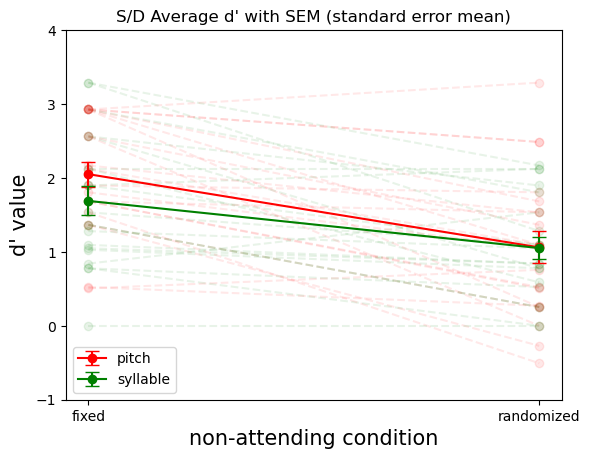

In [3]:
 
# dir1 = "E:/cmu/lab project/result & analysis/SD_result/SD_syllable_Eli"
# dir2 = "E:/cmu/lab project/result & analysis/SD_result/SD_syllable_will"
# dir3 = "E:/cmu/lab project/result & analysis/SD_result/SD_syllable_Sahil"
# dir4 = "E:/cmu/lab project/result & analysis/SD_result/SD_syllable_Audra"
# dir5 = "E:/cmu/lab project/result & analysis/SD_result/SD_syllable_Andrew"
# dir = [dir1, dir2, dir3, dir4, dir5]

# dir = ["D:/New folder/SD"]
# dir = ["E:/cmu/lab project/result & analysis/sona-pilot data & analyze/data_exp_127771-v4"]
dir1 = "E:/cmu/lab project/New folder/data_3_pilots/data_exp_127771-v4"
dir2 = "E:/cmu/lab project/New folder/data-4-27"
dir = [dir1, dir2]

dprime_sum = np.zeros(4)
dprime_list = []

for i in range(len(dir)):
    # use same axis
    df = count(dir[i])

    # group data frame by 'Participant Private ID' column
    grouped = df.groupby('Participant Private ID')
    # create a list of data frames
    list_of_dfs = [group for _, group in grouped]

    for j, df in enumerate(list_of_dfs):
        #print(df)
        dprime = cal_dprime(df)
        #plot_dprime_individual(dprime, j + 1)
        plot_dprime_all(dprime, j + 1 + 3)

        dprime_sum += dprime
        dprime_list.append(dprime)


x = ['fixed', 'randomized']
# x = [4, 6, 8]
# Plot the average d' with error bars
dprime_array = np.array(dprime_list)
dprime_avg = np.mean(dprime_array, axis=0)
dprime_sem = np.std(dprime_array, axis=0) / np.sqrt(len(dprime_list))
#plt.figure()
plt.errorbar(x, dprime_avg[0::2], yerr=dprime_sem[0::2], fmt='ro-', label='pitch', capsize=5)
plt.errorbar(x, dprime_avg[1::2], yerr=dprime_sem[1::2], fmt='go-', label='syllable', capsize=5)
plt.title('S/D Average d\' with SEM (standard error mean)')
plt.xlabel('non-attending condition', fontsize = 15)
plt.ylabel('d\' value')
plt.xticks(x)
plt.ylim([-1, 4])
plt.legend()
plt.show()

In [10]:
# Create a DataFrame
df = pd.DataFrame(dprime_list, columns=['Fixed Pitch', 'Fixed Syllable', 'Randomized Pitch', 'Randomized Syllable'])
print(df)
# Save the DataFrame to a CSV file
df.to_csv('S_D_dprime_result.csv', index=False)

    Fixed Pitch  Fixed Syllable  Randomized Pitch  Randomized Syllable
0      2.926405    7.777476e-01          1.094968         1.110223e-16
1      1.366022    7.777476e-01          0.253347         5.244005e-01
2      2.926405    2.563103e+00          2.486475         7.777476e-01
3      2.563103    1.048801e+00          0.000000         8.416212e-01
4      2.926405    2.123173e+00          1.683242         2.123173e+00
5      1.366022    2.123173e+00         -0.271053         5.882741e-01
6      1.805952    1.028204e+00          1.048801         7.777476e-01
7      2.926405    1.898201e+00          3.289707         2.123173e+00
8      2.123173    3.289707e+00          1.094968         1.281552e+00
9      0.506694    1.094968e+00          0.757151         8.416212e-01
10     0.524401    1.366022e+00          0.271053         2.533471e-01
11     2.169254    2.563103e+00          1.534899         1.898201e+00
12     1.898201    1.898201e+00          1.805952         1.094968e+00
13    

### Statistical-test

#### Library & Function

In [4]:
import numpy as np
from scipy.stats import ttest_ind
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
import pingouin as pg

In [5]:
def process_list(lst, remove_zeros=False):
    lst = np.array(lst)
    lst1 = np.split(lst, lst.shape[1], axis=1)
    # Unpack the list into four arrays
    fix_P, fix_S, rand_P, rand_S = lst1

    # Optionally remove zero elements from the arrays
    if remove_zeros:
        fix_P = fix_P[fix_P != 0]
        fix_S = fix_S[fix_S != 0]
        rand_P = rand_P[rand_P != 0]
        rand_S = rand_S[rand_S != 0]
        # fix_P = fix_P[fix_P > 1]
        # fix_S = fix_S[fix_S > 1]
        # rand_P = rand_P[rand_P > 1]
        # rand_S = rand_S[rand_S > 1]

    # Return the resulting arrays
    return fix_P, fix_S, rand_P, rand_S

#### Data Preprocessing

In [6]:
fix_P, fix_S, rand_P, rand_S = process_list(dprime_list, remove_zeros=False)
# print(fix_P.mean())
# print(fix_S.mean())
# print(rand_P.mean())
# print(rand_S.mean())

fix_P = fix_P.flatten()
fix_S = fix_S.flatten()
rand_P = rand_P.flatten()
rand_S = rand_S.flatten()
# print("Length of fix_P: ", len(fix_P))
# print("Length of fix_S: ", len(fix_S))
# print("Length of rand_P: ", len(rand_P))
# print("Length of rand_S: ", len(rand_S))

In [7]:
# Combine the arrays into a single DataFrame
n_subjects = 20

df = pd.DataFrame({
    'subject': np.tile(np.arange(1, n_subjects+1), 4),
    'task': np.repeat(['S/D','S/D','S/D','S/D'], [len(fix_P), len(fix_S), len(rand_P), len(rand_S)]),
    'attend_condition': np.repeat(['pitch', 'syllable', 'pitch', 'syllable'], [len(fix_P), len(fix_S), len(rand_P), len(rand_S)]),
    'structure': np.repeat(['fixed', 'fixed', 'random', 'random'], [len(fix_P), len(fix_S), len(rand_P), len(rand_S)]),
    'dprime': np.concatenate([fix_P, fix_S, rand_P, rand_S])
})
#print(df)
df.to_csv('SD_dprime.csv', index=False)

mean_dprime = df.groupby(['task', 'attend_condition', 'structure'])['dprime'].mean()
print(mean_dprime)

#save df in a csv file 
mean_dprime_reset = mean_dprime.reset_index() #kept the same column
mean_dprime_reset.to_csv('SD_mean_dprime.csv', index=False)

task  attend_condition  structure
S/D   pitch             fixed        2.051449
                        random       1.060733
      syllable          fixed        1.689618
                        random       1.051652
Name: dprime, dtype: float64


#### Factorial Anova

In [8]:
df1 = pd.read_csv('PA_dprime.csv')
df2 = pd.read_csv('SD_dprime.csv')
df3 = pd.concat([df1, df2])


#perform three-way ANOVA
model = ols("""dprime ~ C(task) +  C(structure) + C(attend_condition) +
               C(task):C(structure) +  C(task):C(attend_condition)+ C(attend_condition):C(structure) + 
               C(structure):C(task):C(attend_condition)""", data=df3).fit()

# sm.stats.anova_lm(model, typ=2)

# Perform the ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Round the values in the table to 2 decimal places
anova_table_rounded = anova_table.round(3)

print(anova_table_rounded)

                                          sum_sq     df       F  PR(>F)
C(task)                                   25.495    1.0  45.906   0.000
C(structure)                               5.037    1.0   9.069   0.003
C(attend_condition)                        0.069    1.0   0.124   0.725
C(task):C(structure)                       8.446    1.0  15.207   0.000
C(task):C(attend_condition)                2.062    1.0   3.712   0.056
C(attend_condition):C(structure)           1.409    1.0   2.537   0.113
C(structure):C(task):C(attend_condition)   0.005    1.0   0.009   0.924
Residual                                  84.418  152.0     NaN     NaN


#### T-test

In [9]:
import numpy as np
from scipy.stats import ttest_ind

def two_sample_ttest(group1, group2, alpha=0.05):
    # Calculate the t-test statistic and p-value
    t_statistic, p_value = ttest_ind(group1, group2)

    # Determine significance level
    if p_value < alpha:
        result = "The difference in means is statistically significant at the {}% confidence level.".format((1-alpha)*100)
    else:
        result = "The difference in means is not statistically significant at the {}% confidence level.".format((1-alpha)*100)

    print("t-statistic:", t_statistic)
    print("p-value:", p_value)
    print(result)

    # Return the results
    return t_statistic, p_value, result


# Perform the t-test and determine significance level
print('Between fixed Pitch and Syllable')
t_statistic, p_value, result = two_sample_ttest(fix_P, fix_S, alpha=0.05)
# print("t-statistic:", t_statistic)
# print("p-value:", p_value)
# print(result)

# Perform the t-test and determine significance level
print('Between randomized Pitch and Syllable')
t_statistic, p_value, result = two_sample_ttest(rand_P, rand_S, alpha=0.05)
# print("t-statistic:", t_statistic)
# print("p-value:", p_value)
# print(result)

# Perform the t-test and determine significance level
print('Between fixed Pitch and randomized Pitch')
t_statistic, p_value, result = two_sample_ttest(fix_P, rand_P, alpha=0.05)
# print("t-statistic:", t_statistic)
# print("p-value:", p_value)
# print(result)

# Perform the t-test and determine significance level
print('Between fixed syllable and randomized syllable')
t_statistic, p_value, result = two_sample_ttest(rand_S, fix_S, alpha=0.05)
# print("t-statistic:", t_statistic)
# print("p-value:", p_value)
# print(result)






Between fixed Pitch and Syllable
t-statistic: 1.356706632957735
p-value: 0.1828800402641191
The difference in means is not statistically significant at the 95.0% confidence level.
Between randomized Pitch and Syllable
t-statistic: 0.03355326820392058
p-value: 0.9734090170342483
The difference in means is not statistically significant at the 95.0% confidence level.
Between fixed Pitch and randomized Pitch
t-statistic: 3.5234762724263193
p-value: 0.0011275000392804424
The difference in means is statistically significant at the 95.0% confidence level.
Between fixed syllable and randomized syllable
t-statistic: -2.496437996600152
p-value: 0.01699900808008821
The difference in means is statistically significant at the 95.0% confidence level.
